C:\Users\anton.kireyeu\Downloads\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\calmap\__init__.py:294: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  by_day = data.resample('D', how=how)


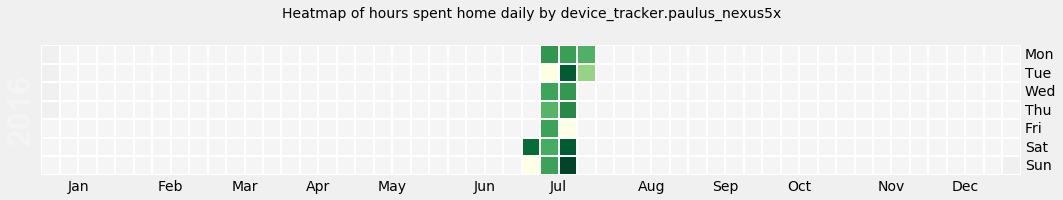

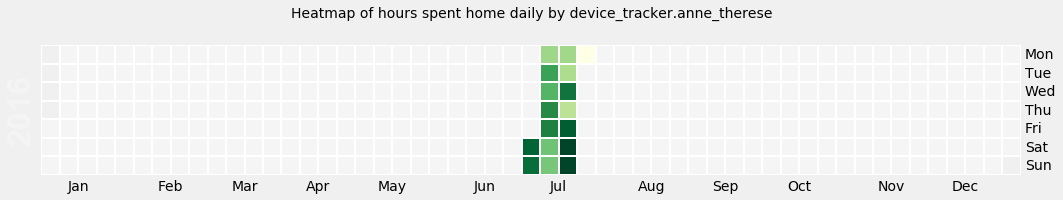

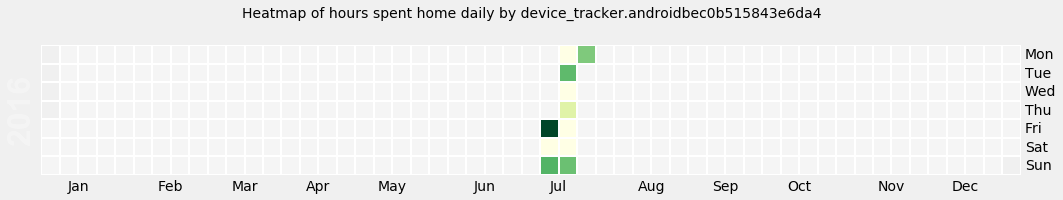

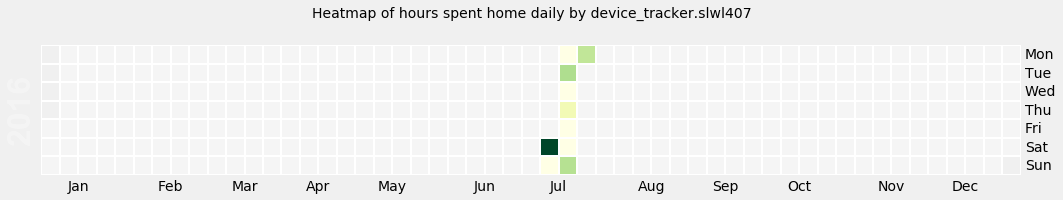

In [23]:
%matplotlib inline
from sqlalchemy import create_engine, text
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltt
import calmap

# setting up a visual style for PyPlot, much better than the standard
pltt.style.use('fivethirtyeight')

# Your database url as specified in configuration.yaml
# If using default settings, it's \
# sqlite:///<path to config dir>/home-assistant_v2.db
DB_URL = "sqlite:///./home-assistant_v3.db"
engine = create_engine(DB_URL)


# let's get a list of distinct entity_ids from domain 'device tracker'
entitystmt = text("select distinct entity_id from states where \
    domain='device_tracker'")
entitiesquery = engine.execute(entitystmt)
entitylist = list(entitiesquery.fetchall())


# now let's loop through the entitylist to generate plots for each entity
for entity in entitylist:

    # sql query pulling each state for a given entity, joining in on itself \
    # in order to get the time of next state change
    stmt = text("select distinct case when t1.state='home' then 1 else 0 end as \
    HomeBit, t1.last_changed, (select  last_changed from states t2 where \
    t2.state_id> t1.state_id and entity_id=:entity_filter order by \
    t2.state_id limit 1) as next_change from states t1 where \
    entity_id=:entity_filter")

    # bind entity parameter to query
    stmt = stmt.bindparams(entity_filter=entity[0])

    # execute the SQL statement
    devicestatesquery = engine.execute(stmt)

    # get rows from query into a pandas dataframe
    devicestatesDF = pd.DataFrame(devicestatesquery.fetchall())

    # name the dataframe rows for usability
    devicestatesDF.columns = ['HomeBit',  'last_changed', 'next_change']

    # create a dataframe with an index ranging from the min to the max\
    # last_changed timestamp from our query
    dates = pd.DataFrame(index=pd.date_range(min(pd.to_datetime(
            devicestatesDF['last_changed']).dt.date.unique()),
            max(pd.to_datetime(devicestatesDF['last_changed']).dt.date.unique()
                )-timedelta(days=1)))

    # create a HomeTime column with a zero timedelta value
    dates['HomeTime'] = timedelta(days=0)

    # create a last_changed_date column with only the date portion of \
    # last_changed value
    devicestatesDF['last_changed_date'] = pd.to_datetime(devicestatesDF
                                    ['last_changed']).apply(lambda x: x.date())

    # grab the index values of our dates dataframe
    dateslist_DATE = pd.to_datetime(dates.index.values.tolist())

    # start processing for each date
    for date in dateslist_DATE:

        # create a filtered dataframe where the last_changed_date column \
        # matches the date currently being processed
        datedf = devicestatesDF.loc[devicestatesDF['last_changed_date'] ==
                                    date.date()]

        # the filtered dataframe will retain the indexes, so let's reset them
        datedf.reset_index(inplace=True)

        # initialize our "counter" as a 0 timedelta
        datetimehomesum = pd.Timedelta(hours=0, unit='us')

        # start processing the filtered dataframe row by row
        for item in datedf.index:

            # if this is the first row of current day
            if item == 0:

                # and the first row of this day indicates that the device \
                # wasn't home, it must've been home for whatever time since \
                # the beginning of current day
                if datedf.ix[item]['HomeBit'] == 0:
                    datetimehomesum += (pd.to_datetime(datedf.ix[item]
                        ['last_changed'])-pd.to_datetime(pd.to_datetime
                        (datedf.ix[item]['last_changed']).date()))*1

                    # if there's more rows to be processed in this day, \
                    # calculate the home value from first timestamp to second
                    if len(datedf.index) > 1:
                        datetimehomesum += (pd.to_datetime(datedf.ix[item]
                            ['next_change'])-pd.to_datetime(datedf.ix[item]
                            ['last_changed']))*datedf.ix[item]['HomeBit']

                # if the first row of this day indicates that the device was\
                # home, calculatee the home value for the first timestamp as \
                # usual
                else:
                    datetimehomesum += (pd.to_datetime(datedf.ix[item]
                            ['next_change'])-pd.to_datetime(datedf.ix[item]
                            ['last_changed']))*datedf.ix[item]['HomeBit']

            # if this is the last row of this day, calculate the home value\
            # until beginning of next day
            elif item == len(datedf.index)-1:
                datetimehomesum += (pd.to_datetime(((pd.to_datetime(datedf.ix
                    [item]['last_changed']))+(timedelta(days=1))).date()) -
                    pd.to_datetime(datedf.ix[item]['last_changed']))\
                    * datedf.ix[item]['HomeBit']

            # otherwise calculate the home value as usual
            else:
                datetimehomesum += (pd.to_datetime(datedf.ix[item]
                    ['next_change'])-pd.to_datetime(datedf.ix[item]
                    ['last_changed']))*datedf.ix[item]['HomeBit']

        # set the value of our dates dataframe at index of current date\
        # to the calculated home value for this day
        dates.loc[date] = datetimehomesum

    # convert index of our dates dataframe to datetime
    dates.index = pd.to_datetime(dates.index, box=True)

    # convert each value in our dates dataframe from an hour timedelta \
    # to a float
    dates = dates.apply(lambda x: x/np.timedelta64(1, 'h'))

    # create a series from our dates dataframe (necessary for calmap)
    datesseries = dates['HomeTime']

    # create a calendar map
    entityplot = calmap.calendarplot(datesseries, cmap='YlGn', fig_kws=dict(figsize=(15, 3)), 
                                linecolor='white')

    # set the plot title to match our current entity name
    entityplot[0].suptitle('Heatmap of hours spent home daily by {}'.format(entity[0]))
    pltt.show()
